In [1]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
train_df = pd.read_csv('train.csv', header=None)
test_df = pd.read_csv('test.csv', header=None)

In [3]:
columns = [f'Pixel-{index}' for index in range(1, 193)]
columns.append('Class-Label')

train_df.columns = columns
test_df.columns = columns

In [4]:
train_df.head()

,Pixel-1,Pixel-2,Pixel-3,Pixel-4,Pixel-5,Pixel-6,Pixel-7,Pixel-8,Pixel-9,Pixel-10,...,Pixel-184,Pixel-185,Pixel-186,Pixel-187,Pixel-188,Pixel-189,Pixel-190,Pixel-191,Pixel-192,Class-Label
0,0,0,1,1,0,0,0,0,0,0,...,0,2,2,0,0,0,0,0,0,6
1,0,0,0,0,0,0,0,0,0,0,...,4,3,0,0,0,0,0,0,0,4
2,0,0,0,0,0,2,2,0,0,0,...,0,4,2,0,0,0,0,0,0,9
3,0,0,0,0,2,4,2,0,0,0,...,0,0,0,0,2,0,0,0,0,8
4,0,0,0,1,4,4,1,0,0,0,...,2,2,2,0,0,0,0,0,0,8


In [5]:
test_df.head()

,Pixel-1,Pixel-2,Pixel-3,Pixel-4,Pixel-5,Pixel-6,Pixel-7,Pixel-8,Pixel-9,Pixel-10,...,Pixel-184,Pixel-185,Pixel-186,Pixel-187,Pixel-188,Pixel-189,Pixel-190,Pixel-191,Pixel-192,Class-Label
0,0,0,0,0,0,2,2,0,0,0,...,0,0,0,4,0,0,0,0,0,9
1,0,0,1,4,4,4,4,0,0,0,...,2,1,0,0,0,0,0,0,0,2
2,0,0,0,0,0,1,2,0,0,0,...,0,0,4,0,0,0,0,0,0,9
3,0,0,0,0,4,4,4,4,0,0,...,0,0,0,4,0,0,0,0,0,7
4,0,0,0,3,2,0,0,3,2,0,...,0,4,0,0,0,0,0,0,0,4


In [4]:
X_train, y_train = train_df.iloc[:, :-1].values, train_df.iloc[:, -1].values
X_test, y_test = test_df.iloc[:, :-1].values, test_df.iloc[:, -1].values

print(f'Shape of the train data : {X_train.shape}\nShape of train labels : {y_train.shape}')
print(f'Shape of the test data : {X_test.shape}\nShape of test labels : {y_test.shape}')

Shape of the train data : (6669, 192)
Shape of train labels : (6669,)
Shape of the test data : (3332, 192)
Shape of test labels : (3332,)


# Neural Network

## Even though neural nets are theoretically complicated to completely understand, the basic implementation of them is really complicated matrix multiplications

## Backprop will be hardcoded here since the activation function used is only sigmoid, if not we need to write an auto-differentiation program to compute the partial differentials

#### More about automatic-differentiation at 

[AutoDifferentiation - Medium](https://towardsdatascience.com/automatic-differentiation-explained-b4ba8e60c2ad)
<br/>
[AutoDifferentiation - Wikipedia](https://en.wikipedia.org/wiki/Automatic_differentiation)

### One thing to note is that popular deeplearning frameworks such as torch, tensorflow are basically autodifferentiation frameworks

![Neural Network](NeuralNetwork.png)

In [7]:
def sigmoid(z: np.ndarray):
    return 1 / (1 + np.exp(-z))


def normalize(z: np.ndarray):
    return (z - z.mean(axis=0)) / z.std(axis=0)


class NeuralNetwork:
    def __init__(self, sizes: list):
        if len(sizes) > 3:
            print('Cannot initialize a Neural Network with more than 2 layers or more than 1 Hidden layer')
        self.X = None  # Feature vectors [shape = (m, n) => (n, m)]
        self.y = None  # Class labels [shape = (m, 1) => (m, k)]
        # Parameters b/w layer-0 and layer-1
        self.W1 = None  # Weights b/w layer-0 and layer-1
        self.b1 = None  # Bias b/w layer-0 and layer-1
        # Parameters b/w layer-1 and layer-2
        self.W2 = None  # Weights b/w layer-1 and layer-2
        self.b2 = None  # Bias b/w layer-1 and layer-2
        self.lr = None  # Learning rate
        self.m, self.n = None, None  # Shape of the data
        self.epochs = None  # Number of epochs
        self.sizes = sizes  # The architecture of the network
        print(f'Initialised 2 Layer Neural Network with {sizes} neurons in each layer')
        print('Note: When passing the data please pass as (m, n)\nWhere,\nm=>number of examples\nn=>feature dimensions')

    def initialize_network(self, X: np.ndarray, y: np.ndarray, lr: float, epochs: int):
        (self.m, self.n) = X.shape
        self.X = X
        assert self.X.shape == (self.m, self.n) # Number of exampless, feature_dims
        assert y.shape == (self.m,) or y.shape == (self.m, 1) or y.shape == (1, self.m)
        num_classes = len(np.unique(y))
        self.y = to_categorical(y).T  # Shape => (num_classes, m)

        assert self.y.shape == (num_classes, self.m)

        n_x, n_h, n_y = self.sizes
        assert n_y == num_classes  # The num_units in the final layer should equal the num_classes

        # Parameters b/w layer-0 and layer-1
        self.W1 = np.random.randn(n_h, n_x) * 0.01
        self.b1 = np.zeros((n_h, 1))
        # Parameters b/w layer-1 and layer-2
        self.W2 = np.random.randn(n_y, n_h) * 0.01
        self.b2 = np.zeros((n_y, 1))
        # Other hyper-parameters
        self.lr = lr
        self.epochs = epochs

        print(f'Received data of shape : {self.X.shape}, Labels of {num_classes} classes of shape : {self.y.shape}')
        print(
            f'Initialized Parameters with the shapes:\nW1 shape : {self.W1.shape}\nb1 shape : {self.b1.shape}\n'
            f'W2 shape : {self.W2.shape}\nb2 shape : {self.b2.shape}\n'
        )

    def forward_propagate(self, X_batch: np.ndarray):
        batch_size = X_batch.shape[-1]
        Z1 = np.dot(self.W1, X_batch) + self.b1  # Shape => (n_h, batch_size)
        A1 = sigmoid(Z1)  # Same shape as Z1
        Z2 = np.dot(self.W2, A1) + self.b2  # Shape => (n_y, batch_size)
        A2 = sigmoid(Z2)  # Same shape as A2

        n_x, n_h, n_y = self.sizes
        assert Z1.shape == (n_h, batch_size) and A1.shape == Z1.shape
        assert Z2.shape == (n_y, batch_size) and A2.shape == Z2.shape

        cache = {
            'Z1': Z1,
            'A1': A1,
            'Z2': Z2,
            'A2': A2
        }
        return A2, cache

    def mse_loss(self, predictions: np.ndarray, y_batch: np.ndarray):
        batch_size = y_batch.shape[-1]  # Calculating the batch size
        assert predictions.shape == y_batch.shape
        assert predictions.shape[-1] == batch_size
        loss = np.square(predictions - y_batch)  # Squared Error
        loss = np.sum(loss) / batch_size  # Mean of the Squared Error
        return loss

    def back_propagate(self, cache: dict, X_batch: np.ndarray, y_batch: np.ndarray):
        A1 = cache['A1']
        A2 = cache['A2']
        
        batch_size = X_batch.shape[-1]
        
        dZ2 = A2 - y_batch
        dW2 = (1 / batch_size) * np.dot(dZ2, A1.T)
        db2 = (1 / batch_size) * np.sum(dZ2, axis=1, keepdims=True)
        dZ1 = np.multiply(np.dot(self.W2.T, dZ2), A1 * (1 - A1))
        dW1 = (1 / batch_size) * np.dot(dZ1, X_batch.T)
        db1 = (1 / batch_size) * np.sum(dZ1, axis=1, keepdims=True)
        
        # dA2 = A2 - y_batch
        # dZ2 = dA2 * A2 * (1 - A2)
        # dW2 = (1 / batch_size) * np.dot(dZ2, A1.T)
        # db2 = (1 / batch_size) * np.sum(dZ2, axis=1, keepdims=True)
        
        # dA1 = np.dot(self.W2.T, dZ2)
        # dZ1 = dA1 * A1 * (1 - A1)
        # dW1 = (1 / batch_size) * np.dot(dZ1, X_batch.T)
        # db1 = (1 / batch_size) * np.sum(dZ1, axis=1, keepdims=True)
        
        grads = {"dW1": dW1,
                 "db1": db1,
                 "dW2": dW2,
                 "db2": db2}
        return grads

    def update_parameters(self, grads):
        dW1 = grads['dW1']
        db1 = grads['db1']
        dW2 = grads['dW2']
        db2 = grads['db2']
        
        self.W1 = self.W1 - self.lr * dW1
        self.b1 = self.b1 - self.lr * db1
        self.W2 = self.W2 - self.lr * dW2
        self.b2 = self.b2 - self.lr * db2

    def get_accuracy(self, predictions: np.ndarray, y_batch):
        assert predictions.shape == y_batch.shape
        
        flat_predictions = np.argmax(predictions, axis=0)
        flat_labels = np.argmax(y_batch, axis=0)
        
        return np.mean(flat_labels == flat_predictions)

    def fit(self, X: np.ndarray, y: np.ndarray, lr: float, epochs: int, verbose: bool, batch_size: int = 32):
        self.initialize_network(X, y, lr, epochs)
        num_batches = int(np.ceil(self.m / batch_size))
        print(f'Batch Size : {batch_size}, data is divided into {num_batches} batches')
        loss_hist = []
        acc_hist = []
        for num_epoch in tqdm(range(self.epochs)):
            for n in range(num_batches):
                X_batch = self.X[n * batch_size: n * batch_size + batch_size].T
                y_batch = self.y[:, n * batch_size: n * batch_size + batch_size]

                predictions, cache = self.forward_propagate(X_batch)
                grads = self.back_propagate(cache, X_batch, y_batch)
                self.update_parameters(grads)
            predictions, cache = self.forward_propagate(self.X.T)
            loss = self.mse_loss(predictions, self.y)
            accuracy = self.get_accuracy(predictions, self.y)
            loss_hist.append(loss)
            acc_hist.append(accuracy)
            if verbose:
                print(
                    f'Epoch {(num_epoch + 1):03}\tLoss : {loss:.3f}\tAccuracy : {accuracy:.2f}')
        return dict(loss=loss_hist, acc=acc_hist)
    
    def predict(self, X_sample: np.ndarray):
        predictions, _ = self.forward_propagate(X_sample.T)
        return np.argmax(predictions, axis=0)

    def evaluate(self, X_sample: np.ndarray, y_sample: np.ndarray):
        predictions, _ = self.forward_propagate(X_sample.T)

        if y_sample.shape[0] == 1 or y_sample.shape[-1] == 1 or y_sample.ndim == 1:
            y_sample = to_categorical(y_sample).T
        loss = self.mse_loss(predictions, y_sample)

        accuracy = self.get_accuracy(predictions, y_sample)
        print(f'Accuracy : {accuracy}, Loss : {loss}')
        return accuracy, loss


In [8]:
neural_net = NeuralNetwork([192, 250, 10])

Initialised 2 Layer Neural Network with [192, 250, 10] neurons in each layer
Note: When passing the data please pass as (m, n)
Where,
m=>number of examples
n=>feature dimensions


In [9]:
history = neural_net.fit(X_train, y_train, 0.01, 150, False, 32)

Received data of shape : (6669, 192), Labels of 10 classes of shape : (10, 6669)
Initialized Parameters with the shapes:
W1 shape : (250, 192)
b1 shape : (250, 1)
W2 shape : (10, 250)
b2 shape : (10, 1)

Batch Size : 32, data is divided into 209 batches


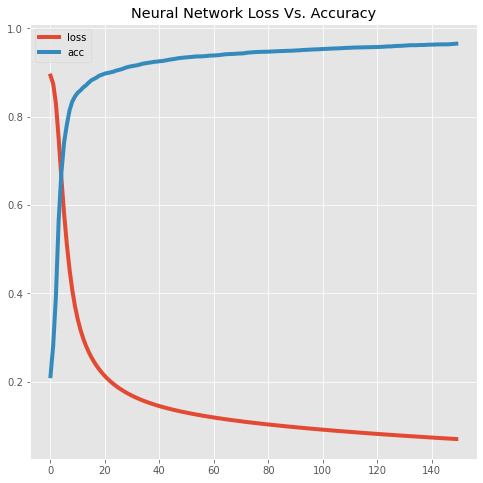

In [10]:
df = pd.DataFrame(history)
fig = df.plot(y=['loss', 'acc'], figsize=(8, 8), lw=4, title='Neural Network Loss Vs. Accuracy').get_figure()

# fig.savefig('Plots/NeuralNetworkLoss.jpeg', dpi=100, quality=95, bbox_inches = 'tight', pad_inches = 0.25)

In [11]:
neural_net.evaluate(X_test, y_test)

Accuracy : 0.9336734693877551, Loss : 0.11265365017166139


(0.9336734693877551, 0.11265365017166139)

In [12]:
test_predictions = neural_net.predict(X_test)

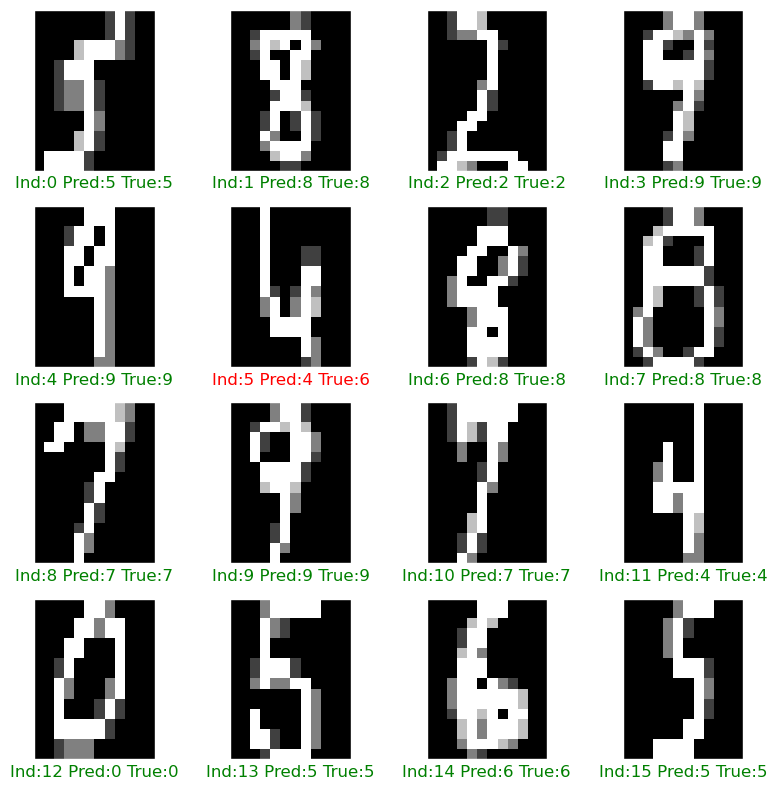

In [13]:
plt.figure(figsize=(8, 8), dpi=100)
start_index = 50

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    prediction = test_predictions[start_index + i]
    true_label = y_test[start_index + i]
    col = 'g' if prediction == true_label else 'r'
    plt.xlabel(f'Ind:{i} Pred:{prediction} True:{true_label}', color=col)
    plt.imshow(np.reshape(X_test[start_index + i], (16, 12)), cmap='gray')

plt.tight_layout()
# plt.savefig('Plots/NeuralNetworkPredictions.jpeg', dpi=100, quality=95)

Predicted : 5, TrueLabel : 5


Text(0.5, 0, 'True : 5, NN : 5, Softmax : 3')

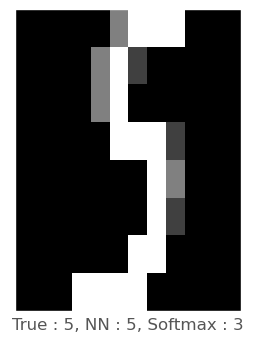

In [14]:
index = 65
sample_image = X_test[index][..., np.newaxis]
prediction, _ = neural_net.forward_propagate(sample_image)
true_label = y_test[index]

print(f'Predicted : {np.argmax(prediction)}, TrueLabel : {true_label}')

plt.figure(figsize=(6, 4), dpi=100)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(np.reshape(sample_image, (16, 12)), cmap='gray')
plt.xlabel(f'True : {true_label}, NN : {5}, Softmax : {3}')
# plt.savefig('Plots/SingleExample.jpeg', dpi=100, quality=95)

Text(2.0, -0.05, 'True label : 5, Predicted : 5')

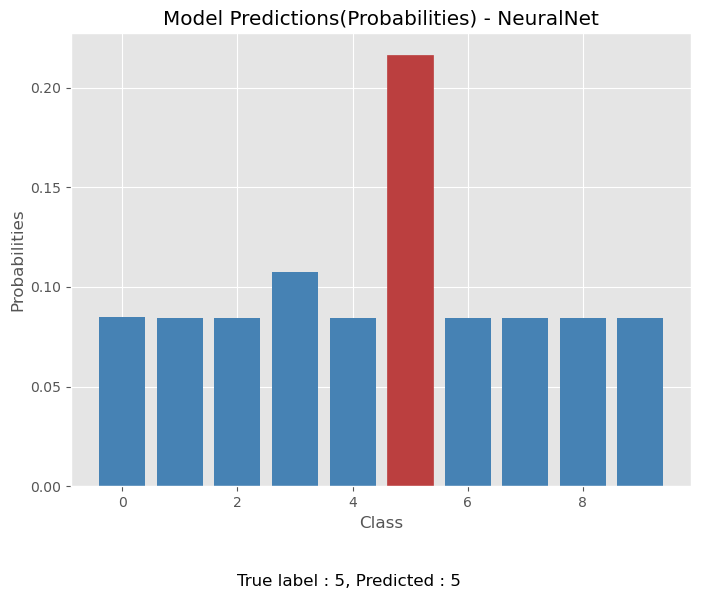

In [15]:
plt.figure(figsize=(8, 6), dpi=100)
softmaxed_pred = np.exp(prediction)
softmaxed_pred = np.squeeze(softmaxed_pred / np.sum(softmaxed_pred))
bars = plt.bar(list(range(10)), softmaxed_pred, color='#4682b4')

bars[np.argmax(prediction)].set_color('#bb3f3f')

plt.title('Model Predictions(Probabilities) - NeuralNet')
plt.xlabel('Class')
plt.ylabel('Probabilities')
plt.text(2.0, -0.05, f'True label : {true_label}, Predicted : {np.argmax(prediction)}', fontsize=12)

# plt.savefig('Plots/NeuralNetSinglePrediction.jpeg', dpi=100, quality=95)

In [16]:
df['loss']

0      0.893087
1      0.874441
2      0.829348
3      0.750593
4      0.661170
         ...   
145    0.071645
146    0.071276
147    0.070910
148    0.070546
149    0.070184
Name: loss, Length: 150, dtype: float64

In [17]:
df['acc'][:-10]

0      0.212626
1      0.282501
2      0.394512
3      0.565002
4      0.673264
         ...   
135    0.962213
136    0.962363
137    0.962363
138    0.962813
139    0.963113
Name: acc, Length: 140, dtype: float64

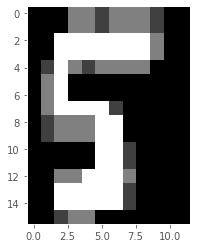

In [14]:
digit = np.squeeze(np.where(y_train == 5))[0]
image = X_train[digit].reshape((16, 12))

plt.imshow(image, cmap='gray')
plt.grid(False)